<a href="https://colab.research.google.com/github/pavangarlapati97/pavan/blob/master/Covid_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U -q kaggle
!mkdir -p ~/.kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"garlapatipavankumar","key":"f76a5a59a7bd1e586a7cb7e6506925ed"}'}

In [4]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database
!ls

 99% 737M/745M [00:44<00:00, 63.2MB/s]
100% 745M/745M [00:44<00:00, 17.4MB/s]
covid19-radiography-database.zip  kaggle.json  sample_data


In [6]:
%%capture
!unzip covid19-radiography-database.zip


In [7]:
import os
import shutil
import random
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import numpy as np
import matplotlib.pyplot as plt

In [8]:
class_names = ['normal', 'pneumonia', 'covid_19', 'lung_opacity']
root_dir = '/content/COVID-19_Radiography_Dataset'
source_dirs = ['Normal', 'Viral Pneumonia', 'COVID', 'Lung_Opacity']

os.mkdir(os.path.join(root_dir, 'train'))
os.mkdir(os.path.join(root_dir, 'test'))
os.mkdir(os.path.join(root_dir, 'val'))

for i, d in enumerate(source_dirs):
    os.renames(
        os.path.join(root_dir, d),
        os.path.join(root_dir, class_names[i])
    )

for c in class_names:
    os.mkdir(os.path.join(root_dir, 'test', c))
    os.mkdir(os.path.join(root_dir, 'val', c))

    images = [i for i in os.listdir(os.path.join(
        root_dir, c)) if i.lower().endswith('png')]
    test_images = random.sample(images, 60)
    images = list(set(images) - set(test_images))
    val_images = random.sample(images, 60)

    for image in test_images:
        shutil.move(
            os.path.join(root_dir, c, image),
            os.path.join(root_dir, 'test', c, image)
        )

    for image in val_images:
        shutil.move(
            os.path.join(root_dir, c, image),
            os.path.join(root_dir, 'val', c, image)
        )

    shutil.move(
        os.path.join(root_dir, c),
        os.path.join(root_dir, 'train')
    )


In [9]:
dirs = {
    'train': '/content/COVID-19_Radiography_Dataset/train',
    'val': '/content/COVID-19_Radiography_Dataset/val',
    'test': '/content/COVID-19_Radiography_Dataset/test'
}

train_set = datasets.ImageFolder(root=dirs['train'], transform=transforms.ToTensor())
val_set = datasets.ImageFolder(root=dirs['val'], transform=transforms.ToTensor())
test_set = datasets.ImageFolder(root=dirs['test'], transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)

In [10]:
train_set.classes

['covid_19', 'lung_opacity', 'normal', 'pneumonia']

In [11]:
train_set.class_to_idx

{'covid_19': 0, 'lung_opacity': 1, 'normal': 2, 'pneumonia': 3}

In [12]:
print(f'Number of Images in Train Set: {len(train_set)}')
print(f'Number of Images in Validation Set: {len(val_set)}')
print(f'Number of Images in Test Set: {len(test_set)}')

Number of Images in Train Set: 20685
Number of Images in Validation Set: 240
Number of Images in Test Set: 240


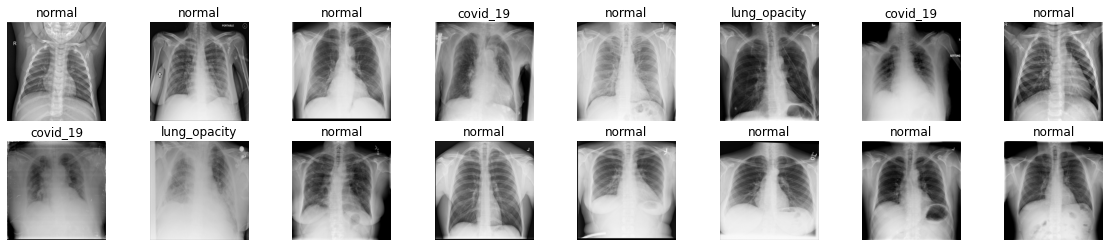

In [13]:
images, labels = next(iter(train_loader))
images = images.numpy()

fig = plt.figure(figsize=(20, 4))
for i in np.arange(16):
    ax = fig.add_subplot(2, 8, i+1)
    ax.axis('off')
    image = np.squeeze(np.transpose(images[i], (1, 2, 0)))
    ax.imshow(image)
    ax.set_title(train_set.classes[labels[i].item()])

plt.show()
plt.close()

In [14]:
freq_train = torch.as_tensor(train_set.targets).bincount()
freq_val = torch.as_tensor(val_set.targets).bincount()
freq_test = torch.as_tensor(test_set.targets).bincount()
freq_all = freq_train + freq_test + freq_val

In [15]:
def log_freq(dset, dfreq):
    for c, i in dset.class_to_idx.items():
        print(f'Number of {c.capitalize()} X-Rays: {dfreq[i].item()}')

In [16]:
print('========== Train Set ==========')
log_freq(train_set, freq_train)
print('======== Validation Set ========')
log_freq(val_set, freq_val)
print('=========== Test Set ===========')
log_freq(test_set, freq_test)

========== Train Set ==========
Number of Covid_19 X-Rays: 3496
Number of Lung_opacity X-Rays: 5892
Number of Normal X-Rays: 10072
Number of Pneumonia X-Rays: 1225
======== Validation Set ========
Number of Covid_19 X-Rays: 60
Number of Lung_opacity X-Rays: 60
Number of Normal X-Rays: 60
Number of Pneumonia X-Rays: 60
=========== Test Set ===========
Number of Covid_19 X-Rays: 60
Number of Lung_opacity X-Rays: 60
Number of Normal X-Rays: 60
Number of Pneumonia X-Rays: 60


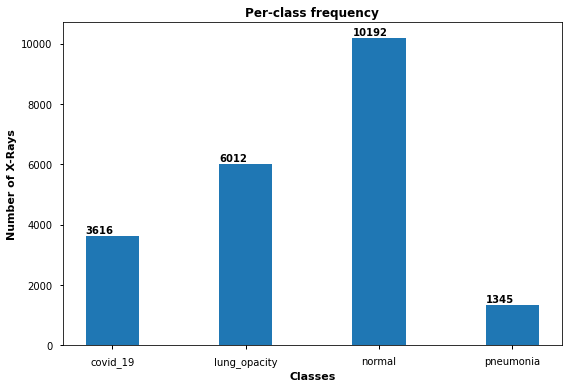

In [17]:
plt.style.use('seaborn-notebook')

plt.bar(train_set.classes, freq_all.numpy(), width=0.4)

for i, v in enumerate(freq_all.numpy()):
    plt.text(i-.2, v+100, str(v), fontweight='bold')

plt.xlabel('Classes', fontweight='bold')
plt.ylabel('Number of X-Rays', fontweight='bold')
plt.title('Per-class frequency', fontweight='bold')

plt.tight_layout()
plt.show()
plt.close()

In [18]:
import csv
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
}


In [31]:
import csv
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dirs = {
    'train': 'data/COVID-19_Radiography_Dataset/train',
    'val': 'data/COVID-19_Radiography_Dataset/val',
    'test': 'data/COVID-19_Radiography_Dataset/test'
}

transform = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ]),
    'eval': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
}


def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()


def get_all_preds(model, loader):
    model.eval()
    with torch.no_grad():
        all_preds = torch.tensor([], device=device)
        for batch in loader:
            images = batch[0].to(device)
            preds = model(images)
            all_preds = torch.cat((all_preds, preds), dim=0)

    return all_preds


def get_confmat(targets, preds):
    stacked = torch.stack(
        (torch.as_tensor(targets, device=device),
         preds.argmax(dim=1)), dim=1
    ).tolist()
    confmat = torch.zeros(4, 4, dtype=torch.int16)
    for t, p in stacked:
        confmat[t, p] += 1

    return confmat


def get_results(confmat, classes):
    results = {}
    d = confmat.diagonal()
    for i, l in enumerate(classes):
        tp = d[i].item()
        tn = d.sum().item() - tp
        fp = confmat[i].sum().item() - tp
        fn = confmat[:, i].sum().item() - tp

        accuracy = (tp+tn)/(tp+tn+fp+fn)
        recall = tp/(tp+fn)
        precision = tp/(tp+fp)
        f1score = (2*precision*recall)/(precision+recall)

        results[l] = [accuracy, recall, precision, f1score]

    return results


def fit(epochs, model, criterion, optimizer, train_dl, valid_dl):
    model_name = type(model).__name__.lower()
    valid_loss_min = np.Inf
    len_train, len_valid = 20685, 240
    fields = [
        'epoch', 'train_loss', 'train_acc', 'valid_loss', 'valid_acc'
    ]
    rows = []

    for epoch in range(epochs):
        train_loss, train_correct = 0, 0
        train_loop = tqdm(train_dl)

        model.train()
        for batch in train_loop:
            images, labels = batch[0].to(device), batch[1].to(device)
            preds = model(images)
            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * labels.size(0)
            train_correct += get_num_correct(preds, labels)

            train_loop.set_description(f'Epoch [{epoch+1:2d}/{epochs}]')
            train_loop.set_postfix(
                loss=loss.item(), acc=train_correct/len_train
            )
        train_loss = train_loss/len_train
        train_acc = train_correct/len_train

        model.eval()
        with torch.no_grad():
            valid_loss, valid_correct = 0, 0
            for batch in valid_dl:
                images, labels = batch[0].to(device), batch[1].to(device)
                preds = model(images)
                loss = criterion(preds, labels)
                valid_loss += loss.item() * labels.size(0)
                valid_correct += get_num_correct(preds, labels)

            valid_loss = valid_loss/len_valid
            valid_acc = valid_correct/len_valid

            rows.append([epoch, train_loss, train_acc, valid_loss, valid_acc])

            train_loop.write(
                f'\n\t\tAvg train loss: {train_loss:.6f}', end='\t'
            )
            train_loop.write(f'Avg valid loss: {valid_loss:.6f}\n')

            # save model if validation loss has decreased
            # (sometimes also referred as "Early stopping")
            if valid_loss <= valid_loss_min:
                train_loop.write('\t\tvalid_loss decreased', end=' ')
                train_loop.write(f'({valid_loss_min:.6f} -> {valid_loss:.6f})')
                train_loop.write('\t\tsaving model...\n')
                torch.save(
                    model.state_dict(),
                    f'lr3e-5_{model_name}_{device}.pth'
                )
                valid_loss_min = valid_loss

    # write running results for plots
    with open(f'/content/COVID-19_Radiography_Dataset/outputs/{model_name}.csv', 'w') as csv_file:
        csv_writer = csv.writer(csv_file)
        csv_writer.writerow(fields)
        csv_writer.writerows(rows)


# worker init function for randomness in multiprocess dataloading
# https://github.com/pytorch/pytorch/issues/5059#issuecomment-817392562
def wif(id):
    process_seed = torch.initial_seed()
    base_seed = process_seed - id
    ss = np.random.SeedSequence([id, base_seed])
    # More than 128 bits (4 32-bit words) would be overkill.
    np.random.seed(ss.generate_state(4))


def load_image(path):
    image = Image.open(path)
    image = transform['eval'](image).unsqueeze(0)
    return image


def deprocess_image(image):
    image = image.cpu().numpy()
    image = np.squeeze(np.transpose(image[0], (1, 2, 0)))
    image = image * np.array((0.229, 0.224, 0.225)) + \
        np.array((0.485, 0.456, 0.406))  # un-normalize
    image = image.clip(0, 1)
    return image


def save_image(image, path):
    # while saving PIL assumes the image is in BGR, and saves it as RGB.
    # But here the image is in RGB, therefore it is converted to BGR first.
    image = image[:, :, ::-1]  # RGB -> BGR
    image = Image.fromarray(image)
    image.save(path)  # saved as RGB
    print(f'GradCAM masked image saved to "{path}".')


In [32]:
def get_densenet121(pretrained=False, out_features=None, path=None):
    model = torchvision.models.densenet121(pretrained=pretrained)
    if out_features is not None:
        model.classifier = torch.nn.Linear(
            in_features=1024, out_features=out_features
        )
    if path is not None:
        model.load_state_dict(torch.load(path, map_location=device))

    return model.to(device)


In [33]:
import cv2
import pandas as pd
import seaborn as sns

def plot_summary(path):
    data = pd.read_csv(path)
    filename = path.split('/')[-1][:-4]

    plt.style.use('seaborn-whitegrid')
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

    ax1.plot(data['epoch'], data['train_loss'], label='Train Loss')
    ax1.plot(data['epoch'], data['valid_loss'], label='Valid Loss')
    ax1.axhline(data['valid_loss'].min(),
                linestyle=(0, (5, 10)), linewidth=0.5)
    ax1.axvline(data['valid_loss'].idxmin(),
                linestyle=(0, (5, 10)), linewidth=0.5)
    ax1.text(11, data['valid_loss'].min(), 'min valid loss',
             backgroundcolor='white', va='center', size=7.5)

    ax2.plot(data['epoch'], data['train_acc'], label='Train Accuracy')
    ax2.plot(data['epoch'], data['valid_acc'], label='Valid Accuracy')

    ax1.legend()
    ax1.set_title('Running Loss', fontweight='bold')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.grid(True)

    ax2.legend()
    ax2.set_title('Running Accuracy', fontweight='bold')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.grid(True)

    plt.tight_layout()
    fig.savefig(f'/content/COVID-19_Radiography_Dataset/outputs/{filename}.png')
    plt.show()
    plt.close()


def plot_confmat(train_mat, test_mat, classes, filename):
    train_mat = pd.DataFrame(train_mat.numpy(), index=classes, columns=classes)
    test_mat = pd.DataFrame(test_mat.numpy(), index=classes, columns=classes)

    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(16, 6))

    ax = fig.add_subplot(121)
    ax = sns.heatmap(train_mat, annot=True, cmap='tab20c',
                     fmt='d', annot_kws={'size': 18})
    ax.set_title('Confusion Matrix (Train Set)', fontweight='bold')
    ax.set_xlabel('Predicted Classes', fontweight='bold')
    ax.set_ylabel('Actual Classes', fontweight='bold')

    ax = fig.add_subplot(122)
    ax = sns.heatmap(test_mat, annot=True, cmap='tab20c',
                     fmt='d', annot_kws={'size': 18})
    ax.set_title('Confusion Matrix (Test Set)', fontweight='bold')
    ax.set_xlabel('Predicted Classes', fontweight='bold')
    ax.set_ylabel('Actual Classes', fontweight='bold')

    plt.tight_layout()
    fig.savefig(f'/content/COVID-19_Radiography_Dataset/outputs/{filename}')
    plt.show()
    plt.close()


def apply_mask(image, mask):
    heatmap = cv2.applyColorMap(np.uint8(255 * mask), cv2.COLORMAP_JET)
    heatmap = np.float32(heatmap) / 255
    cam = heatmap + np.float32(image)
    cam = cam / np.max(cam)
    return np.uint8(255 * cam)


def plot_gradcam(image, dense_cam):
    image = deprocess_image(image)
    name_dict = {
        'Original Image': image,
        'GradCAM (DenseNet-121)': apply_mask(image, dense_cam)
    }

    plt.style.use('seaborn-notebook')
    fig = plt.figure(figsize=(20, 4))
    for i, (name, img) in enumerate(name_dict.items()):
        ax = fig.add_subplot(1, 4, i+1, xticks=[], yticks=[])
        if i:
            img = img[:, :, ::-1]
        ax.imshow(img)
        ax.set_xlabel(name, fontweight='bold')

    fig.suptitle(
        'Localization with Gradient based Class Activation Maps',
        fontweight='bold', fontsize=16
    )
    plt.tight_layout()
    fig.savefig('/content/COVID-19_Radiography_Dataset/outputs/grad_cam.png')
    plt.show()
    plt.close()


In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, WeightedRandomSampler

In [35]:
dirs = {
    'train': '/content/COVID-19_Radiography_Dataset/train',
    'val': '/content/COVID-19_Radiography_Dataset/val',
    'test': '/content/COVID-19_Radiography_Dataset/test'
}
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['train'])
val_set = datasets.ImageFolder(root=dirs['val'], transform=transform['eval'])

In [36]:
class_freq = torch.as_tensor(train_set.targets).bincount()
weight = 1 / class_freq
samples_weight = weight[train_set.targets]
sampler = WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True)

train_dl = DataLoader(train_set, batch_size=32, sampler=sampler, num_workers=2, worker_init_fn=wif)
valid_dl = DataLoader(val_set, batch_size=40)

In [37]:
epochs = 7
criterion = nn.CrossEntropyLoss()

In [38]:
import torch
import torchvision
densenet121 = get_densenet121(pretrained=True, out_features=4)

In [40]:
fit(
    epochs=epochs,
    model=densenet121,
    criterion=criterion,
    optimizer=optim.Adam(densenet121.parameters(), lr=3e-5),
    train_dl=train_dl,
    valid_dl=valid_dl
)

  0%|          | 0/647 [00:00<?, ?it/s]


		Avg train loss: 0.033096	Avg valid loss: 0.135055

		valid_loss decreased (inf -> 0.135055)
		saving model...



  0%|          | 0/647 [00:00<?, ?it/s]


		Avg train loss: 0.029429	Avg valid loss: 0.145005



  0%|          | 0/647 [00:00<?, ?it/s]


		Avg train loss: 0.027503	Avg valid loss: 0.150364



  0%|          | 0/647 [00:00<?, ?it/s]


		Avg train loss: 0.019082	Avg valid loss: 0.133936

		valid_loss decreased (0.135055 -> 0.133936)
		saving model...



  0%|          | 0/647 [00:00<?, ?it/s]


		Avg train loss: 0.021253	Avg valid loss: 0.170625



  0%|          | 0/647 [00:00<?, ?it/s]


		Avg train loss: 0.017098	Avg valid loss: 0.123170

		valid_loss decreased (0.133936 -> 0.123170)
		saving model...



Epoch [ 7/7]: 100%|██████████| 647/647 [08:28<00:00,  1.27it/s, acc=0.995, loss=0.015]



		Avg train loss: 0.016110	Avg valid loss: 0.127955



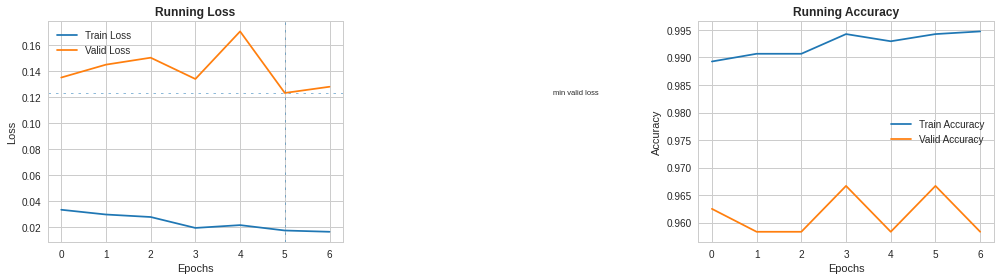

In [41]:
plot_summary('/content/COVID-19_Radiography_Dataset/outputs/densenet.csv')

In [42]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model.eval()
        self.featuremaps = []
        self.gradients = []

        target_layer.register_forward_hook(self.save_featuremaps)
        target_layer.register_backward_hook(self.save_gradients)

    def save_featuremaps(self, module, input, output):
        self.featuremaps.append(output)

    def save_gradients(self, module, grad_input, grad_output):
        self.gradients.append(grad_output[0])

    def get_cam_weights(self, grads):
        return np.mean(grads, axis=(1, 2))

    def __call__(self, image, label=None):
        preds = self.model(image)
        self.model.zero_grad()

        if label is None:
            label = preds.argmax(dim=1).item()

        preds[:, label].backward()

        featuremaps = self.featuremaps[-1].cpu().data.numpy()[0, :]
        gradients = self.gradients[-1].cpu().data.numpy()[0, :]

        weights = self.get_cam_weights(gradients)
        cam = np.zeros(featuremaps.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * featuremaps[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, image.shape[-2:][::-1])
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return label, cam

In [43]:
train_set = datasets.ImageFolder(root=dirs['train'], transform=transform['eval'])
test_set = datasets.ImageFolder(root=dirs['test'], transform=transform['eval'])
train_dl = DataLoader(train_set, batch_size=128)
test_dl = DataLoader(test_set, batch_size=120)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


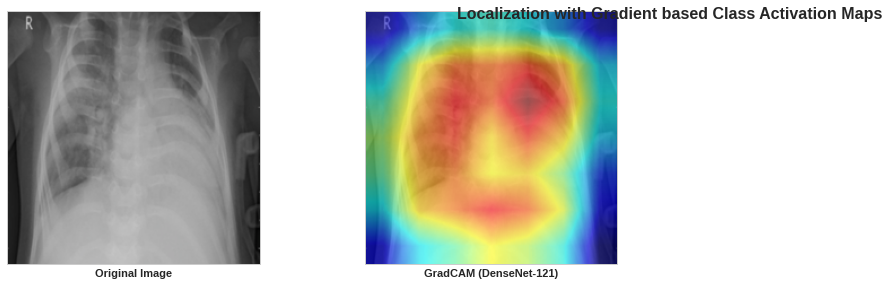

In [63]:
image, label = test_set[200]
image = image.unsqueeze(dim=0).to(device)
cam_obj = GradCAM(model=densenet121, target_layer=densenet121.features[-1])
_, dense_cam = cam_obj(image, label)

plot_gradcam(image,dense_cam)